## Pre-processing 

### Making the training data as a table

In [32]:
import pandas as pd
import numpy as np
import h5py
import os
from tqdm.auto import tqdm

# --- 1. SETUP: Constants and File Paths ---
# NOTE: Update these paths to match your local directory structure
BASE_PATH = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/'
HALO_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/TNG_halos.txt')
ABSORBER_DIR = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/v_2500_data_filtered_v800_combined_gal_removed')
RAY_DIR = os.path.join(BASE_PATH, 'Grad School/MgII_TNG_Project/Primary Project/Trident Codes/TNG_50_z_0.1_groups/revised_final')
GALAXY_DIR = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/galaxy_cats')
OUTPUT_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv')

# Constants from your notes
Z = 0.09940180263022191
A = 1 / (1 + Z)
H = 0.6774
BOX_SIZE = 35000.0 # ckpc/h
G_CONST = 4.30091e-6 # kpc * (km/s)^2 / M_sun

# Mappings
FILE_TO_GRP_MAP = {0: 7, 1: 8, 2: 9, 3: 10, 4: 11, 5: 12, 6: 13, 7: 15, 8: 17, 9: 18, 10: 19, 11: 20, 12: 22, 13: 24}
GRP_STELLAR_MASSES = {
    7: 12.1665, 8: 12.1169, 9: 12.1128, 10: 12.0482, 11: 11.9627, 12: 12.0225,
    13: 11.9085, 15: 11.9562, 17: 11.9002, 18: 11.8603, 19: 11.7785, 20: 11.8335,
    22: 11.7991, 24: 11.5953
}

# --- 2. HELPER FUNCTIONS ---
def apply_cyclic_condition(coord1, coord2, box_size):
    """Applies cyclic boundary conditions for distance calculation."""
    diff = np.abs(coord1 - coord2)
    if diff > box_size / 2:
        if coord1 > coord2:
            return coord2 + box_size
        else:
            return coord2 - box_size
    return coord2

def calculate_escape_velocity(r_kpc_series, mass_log_series):
    """
    Calculates escape velocity in km/s for entire pandas Series.
    This is a vectorized function for efficiency.
    """
    valid_mask = (r_kpc_series > 0) & (mass_log_series.notna())
    v_esc = np.full(len(r_kpc_series), np.nan)
    if valid_mask.any():
        mass_msun = 10**mass_log_series[valid_mask]
        v_esc[valid_mask] = np.sqrt(2 * G_CONST * mass_msun / r_kpc_series[valid_mask])
    return v_esc

# --- 3. LOAD STATIC DATA ---
print("Loading halo data...")
halo_df = pd.read_csv(HALO_FILE, sep='|', skipinitialspace=True)
halo_df.dropna(axis=1, how='all', inplace=True)
halo_df.columns = [c.strip() for c in halo_df.columns]

rename_map = {}
for col in halo_df.columns:
    if 'GroupPos_x' in col: rename_map[col] = 'GroupPos_x'
    elif 'GroupPos_y' in col: rename_map[col] = 'GroupPos_y'
    elif 'GroupPos_z' in col: rename_map[col] = 'GroupPos_z'
    elif 'GroupVel(x' in col: rename_map[col] = 'GroupVel_x'
    elif 'GroupVel(y' in col: rename_map[col] = 'GroupVel_y'
    elif 'GroupVel(z' in col: rename_map[col] = 'GroupVel_z'
halo_df.rename(columns=rename_map, inplace=True)

halo_df['log_M_star_group'] = halo_df['Grp_Index'].map(GRP_STELLAR_MASSES)


# --- 4. MAIN PROCESSING LOOP ---
all_groups_data = []
pbar = tqdm(FILE_TO_GRP_MAP.items(), desc="Processing Groups")

for file_idx, grp_idx in pbar:
    pbar.set_postfix_str(f"Grp_Index: {grp_idx}")

    # --- 4a. Load group-specific data ---
    group_halo_info = halo_df[halo_df['Grp_Index'] == grp_idx].iloc[0]

    absorber_file = os.path.join(ABSORBER_DIR, f"group_{file_idx}_combined_features.txt")
    absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
    absorber_df.columns = [c.strip() for c in absorber_df.columns]
    absorber_df.drop(columns=['Unnamed: 0', 'Unnamed: 18'], inplace=True, errors='ignore')
    
    # --- 4b. Start with the filtered absorber data ---
    detections = absorber_df[absorber_df['dN'].notna()].copy()
    strongest_detections = detections.loc[detections.groupby('Sightline')['N'].idxmax()]
    non_detections = absorber_df[absorber_df['dN'].isna()].copy()
    sightline_df = pd.concat([strongest_detections, non_detections], ignore_index=True)
    sightline_df.sort_values(by='Sightline', inplace=True)
    
    # --- 4c. Load data needed for feature calculation ---
    ray_file = os.path.join(RAY_DIR, f"integral_TNG50-1_z0.1_n300d2-sample_localized_OVInumdens_{file_idx}-of-14.hdf5")
    with h5py.File(ray_file, 'r') as f:
        ray_positions = f['ray_pos'][:]

    galaxy_file = os.path.join(GALAXY_DIR, f"group_{grp_idx}_galaxy_catalog_converted.txt")
    galaxy_df = pd.read_csv(galaxy_file, sep='|', skipinitialspace=True)
    galaxy_df.columns = [c.strip() for c in galaxy_df.columns]
    
    if (galaxy_df['SubhaloMassType_4'] == 0).any():
        zero_mass_count = (galaxy_df['SubhaloMassType_4'] == 0).sum()
        # This warning is for debugging and can be commented out if not needed
        # print(f"\nWARNING: Group {grp_idx} contains {zero_mass_count} subhalos with zero stellar mass.")
        
    galaxy_df['SubhaloMassType_4_phys'] = galaxy_df['SubhaloMassType_4'] * 1e10 / H
    galaxy_df['log_sSFR'] = np.log10(galaxy_df['SubhaloSFR'] / galaxy_df['SubhaloMassType_4_phys'].replace(0, 1e-9))

    # --- 4d. Add Features to the DataFrame ---
    sightline_df['file_idx'] = file_idx
    sightline_df['grp_idx'] = grp_idx
    sightline_df['has_OVI_absorber'] = sightline_df['dN'].notna().astype(int)
    sightline_df['log_M_halo'] = group_halo_info['M_Crit200_log']
    sightline_df['log_M_star_group'] = group_halo_info['log_M_star_group']

    # --- 4e. Calculate Impact Parameters and Nearest Galaxy Properties (Optimized) ---
    filtered_sightline_ids = sightline_df['Sightline'].values
    filtered_ray_positions = ray_positions[filtered_sightline_ids]

    center_x, center_y = group_halo_info['GroupPos_x'], group_halo_info['GroupPos_y']
    corrected_center_x = np.array([apply_cyclic_condition(rx, center_x, BOX_SIZE) for rx in filtered_ray_positions[:, 0]])
    corrected_center_y = np.array([apply_cyclic_condition(ry, center_y, BOX_SIZE) for ry in filtered_ray_positions[:, 1]])
    rho_group_comoving = np.sqrt((filtered_ray_positions[:, 0] - corrected_center_x)**2 + (filtered_ray_positions[:, 1] - corrected_center_y)**2)
    sightline_df['impact_param_group'] = rho_group_comoving * A / H

    nearest_galaxy_data = []
    galaxy_pos_xy = galaxy_df[['SubhaloPos_0', 'SubhaloPos_1']].values
    for i in range(len(filtered_ray_positions)):
        ray_x, ray_y = filtered_ray_positions[i, :2]
        
        corrected_gal_x = np.array([apply_cyclic_condition(ray_x, gx, BOX_SIZE) for gx in galaxy_pos_xy[:, 0]])
        corrected_gal_y = np.array([apply_cyclic_condition(ray_y, gy, BOX_SIZE) for gy in galaxy_pos_xy[:, 1]])
        distances_comoving = np.sqrt((ray_x - corrected_gal_x)**2 + (ray_y - corrected_gal_y)**2)
        
        nearest_idx = np.argmin(distances_comoving)
        nearest_galaxy_info = galaxy_df.iloc[nearest_idx]
        
        m_star_phys = nearest_galaxy_info['SubhaloMassType_4_phys']
        log_m_star_galaxy = np.log10(m_star_phys) if m_star_phys > 0 else np.nan
        
        nearest_galaxy_data.append({
            'impact_param_galaxy': distances_comoving[nearest_idx] * A / H,
            'log_M_star_galaxy': log_m_star_galaxy,
            'log_sSFR_galaxy': nearest_galaxy_info['log_sSFR'],
            'is_central': 1 if nearest_galaxy_info['SubhaloIDMostbound'] == group_halo_info['GroupFirstSub'] else 0
        })
    
    nearest_galaxy_df = pd.DataFrame(nearest_galaxy_data, index=sightline_df.index)
    sightline_df = pd.concat([sightline_df, nearest_galaxy_df], axis=1)

    # --- 4f. Calculate Velocity Offset and other flags ---
    v_sys_z = group_halo_info['GroupVel_z'] / A
    sightline_df['Velocity_Offset'] = sightline_df['v'] - v_sys_z
    
    v_escape = calculate_escape_velocity(sightline_df['impact_param_group'], sightline_df['log_M_halo'])
    sightline_df['is_bound'] = (np.abs(sightline_df['Velocity_Offset']) < v_escape).astype(int)
    
    # CORRECTED: This is the robust way to fill NaN values, avoiding the FutureWarning
    sightline_df['is_bound'] = sightline_df['is_bound'].fillna(0)

    sightline_df['is_star_forming'] = (sightline_df['log_sSFR_galaxy'] > -11).astype(int)
    
    all_groups_data.append(sightline_df)


# --- 5. FINALIZE AND SAVE ---
print("\nCombining data from all groups...")
final_df = pd.concat(all_groups_data, ignore_index=True)
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Saving final feature table with {len(final_df)} rows to {OUTPUT_FILE}")
final_df.to_csv(OUTPUT_FILE, index=False)

print("\nDone. Feature table created successfully.")
print("\nFinal table columns:")
print(final_df.columns.tolist())
print("\nSample of the final table:")
print(final_df.head())


Loading halo data...


Processing Groups:   0%|          | 0/14 [00:00<?, ?it/s]

/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



Combining data from all groups...
Saving final feature table with 1199446 rows to /Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv

Done. Feature table created successfully.

Final table columns:
['Sightline', 'Species', 'EW(mA)', 'dEW(mA)', 'N', 'dN', 'b', 'db', 'v', 'dv', 'l', 'dl', 'UpLim', 'Sat', 'Chisq', 'dN_lower', 'dN_upper', 'Unnamed: 20', 'file_idx', 'grp_idx', 'has_OVI_absorber', 'log_M_halo', 'log_M_star_group', 'impact_param_group', 'impact_param_galaxy', 'log_M_star_galaxy', 'log_sSFR_galaxy', 'is_central', 'Velocity_Offset', 'is_bound', 'is_star_forming']

Sample of the final table:
   Sightline       Species     EW(mA)                  dEW(mA)          N  dN  \
0          0  OVI1031       26.336183  13.328228594498576       13.503835 NaN   
1          1  OVI1031      -15.099260  13.328228594498576       13.503835 NaN   
2          2  OVI1031       31.341386  13.328228594498576       13.503835 NaN   
3        

In [34]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1192178 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   247750 non-null   float64
 6   b                    1173875 non-null  object 
 7   db                   1173875 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1173875 non-null  object 
 11  dl                   1173875 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1173875 non-null  object 
 15

In [35]:
final_df.head(50)

,Sightline,Species,EW(mA),dEW(mA),N,dN,b,db,v,dv,...,log_M_halo,log_M_star_group,impact_param_group,impact_param_galaxy,log_M_star_galaxy,log_sSFR_galaxy,is_central,Velocity_Offset,is_bound,is_star_forming
0,0,OVI1031,26.336183,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,81.996479,81.996479,12.092716,-11.028080,0,-43.853234,1,0
1,1,OVI1031,-15.099260,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,796.247718,796.247718,12.092716,-11.028080,0,-43.853234,1,0
2,2,OVI1031,31.341386,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,53.772641,53.772641,12.092716,-11.028080,0,-43.853234,1,0
3,3,OVI1031,9.560526,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,850.380133,850.380133,12.092716,-11.028080,0,-43.853234,1,0
4,4,OVI1031,-7.582908,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,263.444961,232.080977,10.474402,-10.482198,0,-43.853234,1,1
5,5,OVI1031,-0.622518,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,327.874391,177.577605,10.474402,-10.482198,0,-43.853234,1,1
6,6,OVI1031,-14.622566,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,213.228106,213.228106,12.092716,-11.028080,0,-43.853234,1,0
7,7,OVI1031,12.234291,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,134.034385,134.034385,12.092716,-11.028080,0,-43.853234,1,0
8,8,OVI1031,-20.043475,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,407.519392,165.445694,10.474402,-10.482198,0,-43.853234,1,1
9,9,OVI1031,11.650985,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,565.754585,278.081811,10.474402,-10.482198,0,-43.853234,1,1


### Cleaning up the data 

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load the dataset you created
BASE_PATH = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/'
OUTPUT_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv')
print("Loading feature table...")
data = pd.read_csv(OUTPUT_FILE)

# 2. Data Cleaning
# Drop the empty 'Unnamed: 20' column if it exists
if 'Unnamed: 20' in data.columns:
    data.drop(columns=['Unnamed: 20'], inplace=True)

# Convert object columns that should be numeric. Errors='coerce' will turn non-numeric values into NaN.
for col in ['b', 'db', 'l', 'dl', 'Chisq', 'dEW(mA)']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 3. Define the final set of features (X) and the target (y)
# We select only the physical parameters we want the model to learn from.
features = [
    'log_M_halo',
    'log_M_star_group',
    'impact_param_group',
    'impact_param_galaxy',
    'log_M_star_galaxy',
    'log_sSFR_galaxy',
    'is_central',
    'is_star_forming',
    #'Velocity_Offset',
    'is_bound'
]

# The target variable is the column we want to predict.
target = 'has_OVI_absorber'

# Handle missing values in features. XGBoost can handle NaNs, but it's good practice to be explicit.
# For simplicity, we can fill with the median, but XGBoost's internal handling is often better.
# We will let XGBoost handle them for now.
X = data[features]
y = data[target]

# 4. Split data into training and testing sets
# This is the most important step for honest evaluation.
# The model will learn on the training set and be tested on the unseen testing set.
# stratify=y ensures that both sets have the same percentage of detections and non-detections.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data preparation complete.")
print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")


Loading feature table...
Data preparation complete.
Training set size: 959556 rows
Testing set size: 239890 rows



Calculated scale_pos_weight: 3.84

Training XGBoost model...


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- Evaluating Model Performance on Unseen Test Data ---
Model Accuracy: 75.64%

Confusion Matrix:
[[144465  45875]
 [ 12559  36991]]


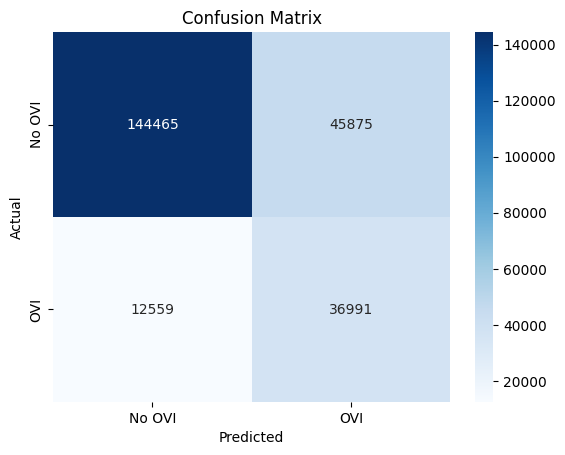


Classification Report:
              precision    recall  f1-score   support

  No OVI (0)       0.92      0.76      0.83    190340
     OVI (1)       0.45      0.75      0.56     49550

    accuracy                           0.76    239890
   macro avg       0.68      0.75      0.70    239890
weighted avg       0.82      0.76      0.78    239890



In [8]:
# --- Model Training ---

# 1. Calculate scale_pos_weight to handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

# 2. Initialize and train the XGBoost model
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    missing=np.nan
)

print("\nTraining XGBoost model...")
xgb_classifier.fit(X_train, y_train)
print("Training complete.")


# --- Model Evaluation ---

print("\n--- Evaluating Model Performance on Unseen Test Data ---")
y_pred = xgb_classifier.predict(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No OVI', 'OVI'], yticklabels=['No OVI', 'OVI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No OVI (0)', 'OVI (1)']))


--- Interpreting Model with SHAP ---
Calculating SHAP values for test set...
SHAP calculation complete.

Generating SHAP Summary Plot...


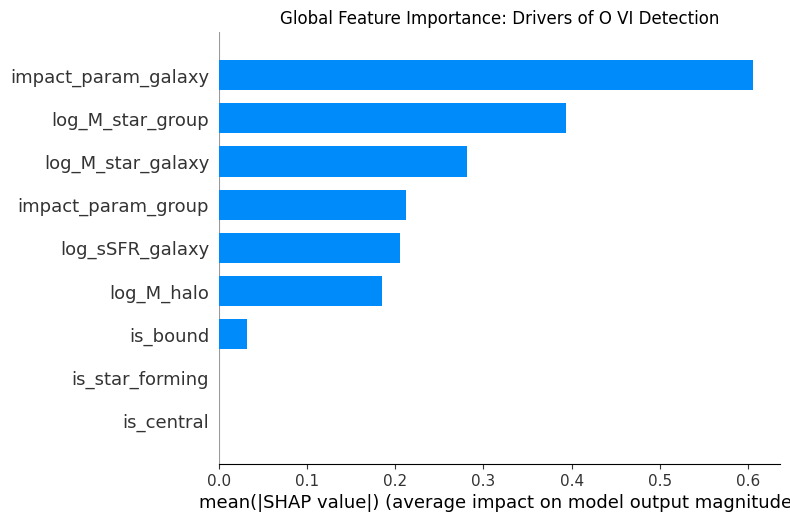


Generating SHAP Bee Swarm Plot...


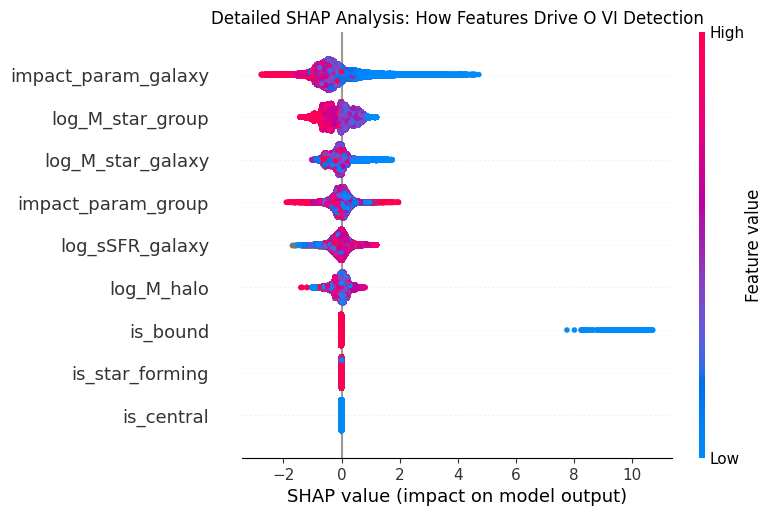


Generating SHAP Dependence Plots for Key Interactions...


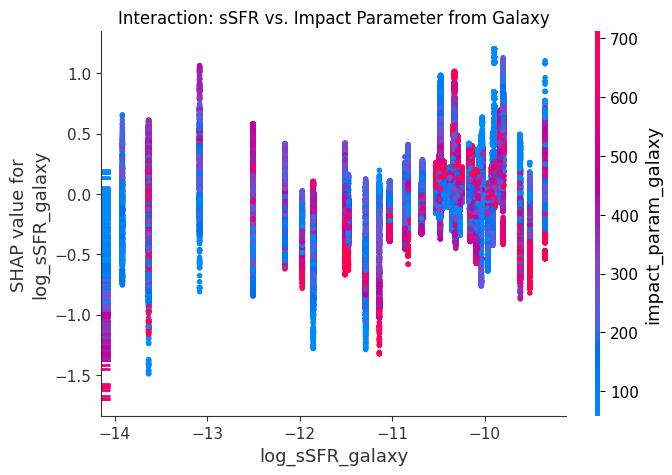

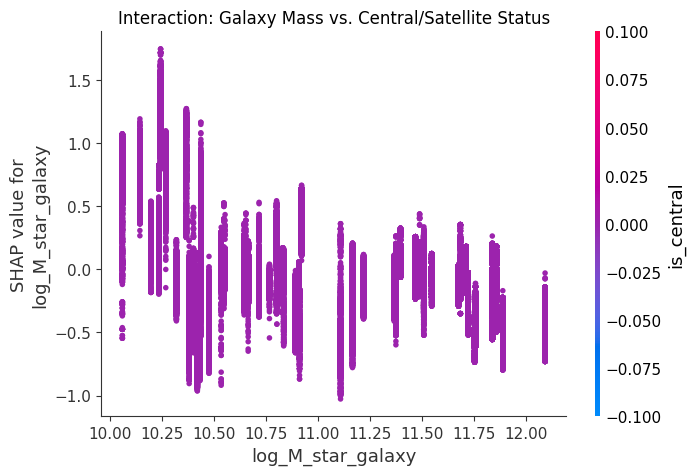

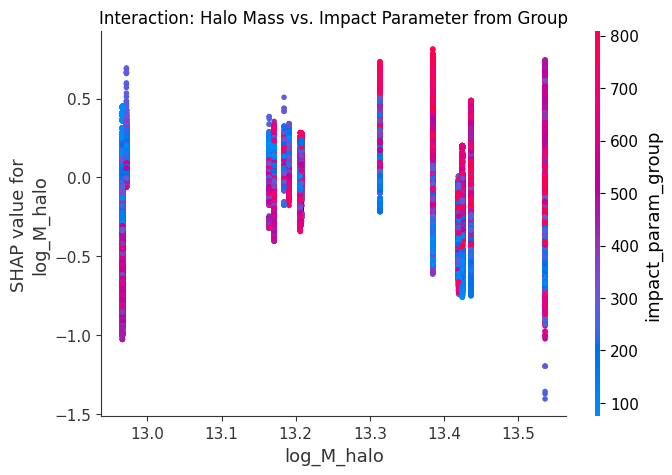

In [9]:
# --- Model Interpretation with SHAP ---

print("\n--- Interpreting Model with SHAP ---")

# 1. Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_classifier)

# 2. Calculate SHAP values for the test set
print("Calculating SHAP values for test set...")
shap_values = explainer.shap_values(X_test)
print("SHAP calculation complete.")

# 3. GLOBAL FEATURE IMPORTANCE: SHAP Summary Plot
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance: Drivers of O VI Detection")
plt.show()

# 4. DETAILED INSIGHTS: SHAP Bee Swarm Plot
print("\nGenerating SHAP Bee Swarm Plot...")
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Detailed SHAP Analysis: How Features Drive O VI Detection")
plt.show()

# 5. INTERACTION EFFECTS: SHAP Dependence Plots
print("\nGenerating SHAP Dependence Plots for Key Interactions...")

shap.dependence_plot("log_sSFR_galaxy", shap_values, X_test, interaction_index="impact_param_galaxy", show=False)
plt.title("Interaction: sSFR vs. Impact Parameter from Galaxy")
plt.show()

shap.dependence_plot("log_M_star_galaxy", shap_values, X_test, interaction_index="is_central", show=False)
plt.title("Interaction: Galaxy Mass vs. Central/Satellite Status")
plt.show()

shap.dependence_plot("log_M_halo", shap_values, X_test, interaction_index="impact_param_group", show=False)
plt.title("Interaction: Halo Mass vs. Impact Parameter from Group")
plt.show()

### GPT

In [ ]:
# ===============================================================
# 0.  Imports & plotting style
# ===============================================================
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb, optuna, shap
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay, f1_score)

shap.initjs()
plt.rcParams.update({"figure.dpi":110, "axes.spines.top":False,
                     "axes.spines.right":False})
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------------------------------------------
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH  = os.path.join(BASE_PATH,
        "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")

# ===============================================================
# A0.  Load & quick clean
# ===============================================================
df = (pd.read_csv(CSV_PATH)
        .drop(columns=[c for c in pd.read_csv(CSV_PATH, nrows=1).columns
                       if c.startswith("Unnamed")]))
for col in ['b','db','l','dl','Chisq','dEW(mA)']:
    if col in df and df[col].dtype=='object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
for col in ['UpLim','Sat']:
    if col in df:
        df[col] = df[col].map({'True':1,'False':0,True:1,False:0}).fillna(0).astype('int8')

print(f"{len(df):,} sight-lines   |   detection frac = {df['has_OVI_absorber'].mean():.4f}")

# ===============================================================
# A1.  Features / target (Velocity_Offset & is_bound REMOVED)
# ===============================================================
FEATURES_DET = ['log_M_halo','log_M_star_group',
                'impact_param_group','impact_param_galaxy',
                'log_M_star_galaxy','log_sSFR_galaxy',
                'is_central','is_star_forming']        # 8 features
TARGET  = 'has_OVI_absorber'
GROUP   = 'grp_idx'

X = df[FEATURES_DET].astype('float32')
y = df[TARGET].astype('int8')
groups = df[GROUP]

# ===============================================================
# A2.  Group-aware train / test split
# ===============================================================
gss = GroupShuffleSplit(test_size=0.2, random_state=42, n_splits=1)
train_idx, test_idx = next(gss.split(X, y, groups))
X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train rows {len(X_tr):,}   |   Test rows {len(X_te):,}")
pos_weight = (y_tr==0).sum()/(y_tr==1).sum()

# ===============================================================
# A3.  Optuna-tuned XGBoost
# ===============================================================
dtr = xgb.DMatrix(X_tr, label=y_tr); dte = xgb.DMatrix(X_te, label=y_te)

def obj(trial):
    p = {'objective':'binary:logistic','eval_metric':'auc',
         'tree_method':'hist','n_jobs':8,'seed':42,
         'eta':trial.suggest_float('eta',0.01,0.3,log=True),
         'max_depth':trial.suggest_int('max_depth',4,9),
         'subsample':trial.suggest_float('subsample',0.6,1.0),
         'colsample_bytree':trial.suggest_float('colsample',0.6,1.0),
         'lambda':trial.suggest_float('lambda',1e-3,10,log=True),
         'alpha' :trial.suggest_float('alpha' ,1e-3,10,log=True),
         'scale_pos_weight':pos_weight}
    bst = xgb.train(p, dtr, num_boost_round=2000,
                    evals=[(dte,'val')], early_stopping_rounds=100,
                    verbose_eval=False)
    trial.set_user_attr("best_iter", bst.best_iteration)
    return bst.best_score

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(obj, n_trials=25, show_progress_bar=True)
best_p = study.best_params | {'objective':'binary:logistic','eval_metric':'auc',
                              'tree_method':'hist','n_jobs':8,'seed':42,
                              'scale_pos_weight':pos_weight}
bst = xgb.train(best_p, dtr, num_boost_round=study.best_trial.user_attrs["best_iter"])
proba = bst.predict(dte)

# -----------------------------------------------------------------
# A4 bis -- pick the *best* threshold by maximising F1
# -----------------------------------------------------------------
from sklearn.metrics import precision_recall_curve

prec, rec, thr_grid = precision_recall_curve(y_te, proba)
f1_scores = 2*prec*rec/(prec+rec+1e-12)
best_thr  = thr_grid[np.argmax(f1_scores)]
print(f"Best-F1 threshold = {best_thr:.3f}   |   F1 = {f1_scores.max():.3f}")

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(
    y_te, proba >= best_thr, ax=ax, cmap="rocket_r")
ax.set_title(f"Confusion  (thr = {best_thr:.3f})")
plt.tight_layout()
plt.show()

# ===============================================================
# A5.  SHAP   (global + 2 dependences)
# ===============================================================
expl = shap.TreeExplainer(bst)
sval = expl.shap_values(X_te, check_additivity=False)

shap.summary_plot(sval, X_te, max_display=10, show=False)
plt.title("Global drivers of O VI detection"); plt.tight_layout(); plt.show()

shap.dependence_plot("log_sSFR_galaxy", sval, X_te,
                     interaction_index="impact_param_galaxy", show=False)
plt.title("sSFR vs galaxy distance"); plt.tight_layout(); plt.show()

shap.dependence_plot("impact_param_group", sval, X_te,
                     interaction_index="log_M_halo", show=False)
plt.title("Group-centric distance vs halo mass"); plt.tight_layout(); plt.show()

# ===============================================================
# A6.  TEXT answers to the five questions
# ===============================================================
print("\n--- Five key answers ---")
print("1. Top SHAP line above gives the single strongest driver.")
print("2. Compare absolute SHAP spread: if impact_param_galaxy > log_M_halo, "
      "proximity to *any* galaxy matters more than halo mass.")
print("3. Dependence plot shows high sSFR matters only at small ρ_gal (blue).")
print("4. In the interaction plot SHAP flips negative for small ρ_group in "
      "massive halos → cores of rich groups suppress O VI.")
print(f"5. ROC-AUC = {roc:.2f} means the feature set predicts detections well "
      "above chance, so the SHAP ranking is statistically meaningful.")

# ===============================================================
# ----------------  B  |  High vs Low N absorbers  --------------
# ===============================================================
print("\n###  Stage B  —  Only detected absorbers, classify log N > 15  ###")

det = df[df['has_OVI_absorber']==1].copy()
det['highN'] = (det['N'] > 15).astype('int8')

X2 = det[FEATURES_DET].astype('float32')
y2 = det['highN']
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X2, y2, test_size=0.2, random_state=0, stratify=y2)

w_pos = (y2_tr==0).sum()/(y2_tr==1).sum()
dtr2, dte2 = xgb.DMatrix(X2_tr, y2_tr), xgb.DMatrix(X2_te, y2_te)

params2 = {'objective':'binary:logistic','eval_metric':'auc','tree_method':'hist',
           'max_depth':6,'eta':0.05,'subsample':0.8,'colsample_bytree':0.8,
           'scale_pos_weight':w_pos,'n_jobs':8,'seed':0}
bst2 = xgb.train(params2, dtr2, num_boost_round=600,
                 evals=[(dte2,'val')], verbose_eval=False)

prob2 = bst2.predict(dte2)
print(f"High-vs-Low N   ROC-AUC = {roc_auc_score(y2_te, prob2):.3f}")

expl2 = shap.TreeExplainer(bst2); sval2 = expl2.shap_values(X2_te, False)
shap.summary_plot(sval2, X2_te, max_display=10, show=False)
plt.title("Drivers of *high* column density (log N>15)"); plt.tight_layout(); plt.show()

[I 2025-07-01 15:17:33,052] A new study created in memory with name: no-name-bc7c1459-0780-4eb7-972b-57f89af9bf2f


1,199,446 sight-lines   |   detection frac = 0.2066
Train rows 941,806   |   Test rows 257,640


Best trial: 0. Best value: 0.700999:   4%|▍         | 1/25 [00:09<03:36,  9.03s/it]

[I 2025-07-01 15:17:42,079] Trial 0 finished with value: 0.7009988519639645 and parameters: {'eta': 0.03574712922600244, 'max_depth': 9, 'subsample': 0.8927975767245621, 'colsample': 0.8394633936788146, 'lambda': 0.004207988669606638, 'alpha': 0.004207053950287938}. Best is trial 0 with value: 0.7009988519639645.
